In [4]:
!pip install tikzplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 kB 2.0 MB/s eta 0:00:00


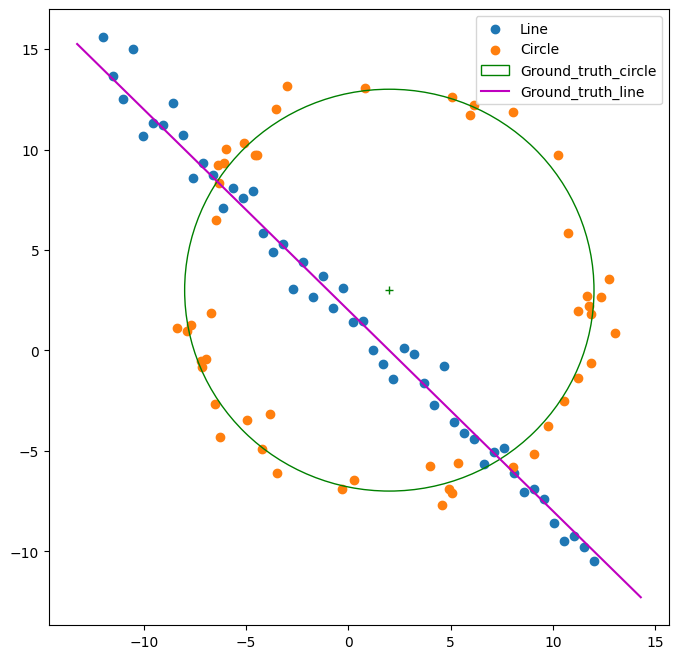

In [13]:
import numpy as np
from scipy.optimize import minimize
from scipy import linalg

import matplotlib.pyplot as plt
import tikzplotlib

# np.random.seed(0)
N = 100
half_n = N // 2

r = 10
x0_gt, y0_gt = 2, 3  # Center
s = r / 16
t = np.random.uniform(0, 2 * np.pi, half_n)
n = s * np.random.randn(half_n)
x, y = x0_gt + (r + n) * np.cos(t), y0_gt + (r + n) * np.sin(t)
X_circ = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

s = 1.
m, b = -1, 2
x = np.linspace(-12, 12, half_n)
y = m * x + b + s * np.random.randn(half_n)
X_line = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

X = np.vstack((X_circ, X_line))  # All points

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(X_line[:, 0], X_line[:, 1], label='Line')
ax.scatter(X_circ[:, 0], X_circ[:, 1], label='Circle')

circle_gt = plt.Circle((x0_gt, y0_gt), r, color='g', fill=False, label='Ground_truth_circle')
ax.add_patch(circle_gt)
ax.plot((x0_gt), (y0_gt), '+', color='g')

x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = m * x_ + b
plt.plot(x_, y_, color='m', label='Ground_truth_line')

plt.legend()
plt.show()

In [24]:
import numpy as np
from scipy.optimize import minimize

def ransac_line(X, line_max_iterations=100, line_threshold=1.0, line_data_fraction=0.4, line_sample=2):
    """
    Perform RANSAC-based line fitting using total least squares to minimize the distance of points to the estimated line.

    Parameters:
    -----------
    X : ndarray
        The set of 2D points (N x 2) where each row is a point [x, y].
    line_max_iterations : int, optional
        The maximum number of iterations for RANSAC to try different line models (default=100).
    line_threshold : float, optional
        The distance threshold for classifying points as inliers (default=1.0).
    line_data_fraction : float, optional
        The fraction of the total data points that must be in the consensus set to accept a model (default=0.4).
    line_sample : int, optional
        The number of points randomly sampled in each iteration (default=2).

    Returns:
    --------
    best_line_model : ndarray
        The best line model parameters [a, b, d] where:
        - [a, b] is the unit normal vector to the line.
        - d is the perpendicular distance from the origin.
    best_line_inliers : ndarray
        A boolean array indicating which points are classified as inliers for the best model.
    """
    N = X.shape[0]  # Number of points
    line_data_points = int(line_data_fraction * N)  # Minimum number of inliers for consensus
    line_best_error = np.inf  # Track the best error

    best_line_model = []
    best_line_inliers = []

    # Total least squares error function
    def line_total_error(x, line_indices):
        a, b, d = x[0], x[1], x[2]
        return np.sum(np.square(a * X[line_indices, 0] + b * X[line_indices, 1] - d))

    # Constraint: ensure that [a, b]^T is a unit vector
    def cons(x):
        return x[0] ** 2 + x[1] ** 2 - 1

    constraint = ({'type': 'eq', 'fun': cons})

    # Consensus set: find points within threshold distance to the estimated line
    def line_consensus_set(X, x, line_threshold):
        a, b, d = x[0], x[1], x[2]
        error = np.abs(a * X[:, 0] + b * X[:, 1] - d)
        return error < line_threshold

    # RANSAC iterations
    for line_iteration in range(line_max_iterations):
        # Randomly select a small sample of points
        line_indices = np.random.randint(0, N, line_sample)

        # Initial guess for [a, b, d]
        x0 = np.array([1, 1, 0])

        # Minimize total error to find the best line model for the current sample
        res = minimize(line_total_error, x0=x0, args=(line_indices,), tol=1e-6, constraints=constraint)

        # Find the inliers (consensus set) for the current model
        line_inliers = line_consensus_set(X, res.x, line_threshold)

        # Check if the number of inliers exceeds the required threshold
        if np.sum(line_inliers) > line_data_points:
            # Refine the model using all inliers
            x0 = res.x
            res = minimize(line_total_error, x0=x0, args=(line_inliers,), tol=1e-6, constraints=constraint)

            # Update the best model if the error improves
            if res.fun < line_best_error:
                line_best_error = res.fun
                best_line_model = res.x
                best_line_inliers = line_inliers

    return best_line_model, best_line_inliers



In [25]:
def ransac_circle(X, best_line_inliers, circle_threshold=1.0, max_circle_iterations=100, circle_sample=3, circle_num_data=35):
    """
    Perform RANSAC-based circle fitting to find the best-fitting circle for the remaining points (after line removal).
    """
    # Separate the points that are not part of the line (the "remnants")
    line_outliers = np.where(best_line_inliers == False)[0]
    remnants = X[line_outliers]

    # Circle fitting total least squares error function
    def circle_tls(x, indices):
        x0, y0, r = x
        x1, y1 = remnants[indices].T
        return np.sum((np.sqrt((x1 - x0)**2 + (y1 - y0)**2) - r)**2)

    # Consensus set for the circle: check points within the threshold distance to the estimated circle
    def circle_consensus_set(remnants, x, circle_threshold):
        distances = np.abs(np.linalg.norm(remnants - x[:2], axis=1) - x[2])
        return distances < circle_threshold

    # Initialize variables for RANSAC
    circle_best_model = []
    circle_best_inliers = []
    circle_best_error = np.inf
    circle_best_indices = []

    # RANSAC iterations
    for circle_iteration in range(max_circle_iterations):
        # Randomly select a sample of points
        circle_indices = np.random.randint(0, len(remnants), circle_sample)

        # Initial guess for [x0, y0, r]
        x0 = np.array([0, 0, 0])

        # Minimize total least squares error to find the best circle model for the current sample
        res = minimize(circle_tls, x0, args=circle_indices, tol=1e-6)

        # Find the inliers (consensus set) for the current model
        circle_inliers = circle_consensus_set(remnants, res.x, circle_threshold)

        # Check if the number of inliers exceeds the required threshold
        if np.sum(circle_inliers) > circle_num_data:
            # Refine the model using all inliers
            x0 = res.x
            res = minimize(circle_tls, x0=x0, args=(circle_inliers,), tol=1e-6)

            # Update the best model if the error improves
            if res.fun < circle_best_error:
                circle_best_error = res.fun
                circle_best_indices = circle_indices
                circle_best_model = res.x
                circle_best_inliers = circle_inliers

    # Ensure circle_best_inliers matches the length of remnants
    circle_best_inliers = np.array(circle_best_inliers[:len(remnants)])

    return circle_best_model, circle_best_inliers, circle_best_indices , remnants




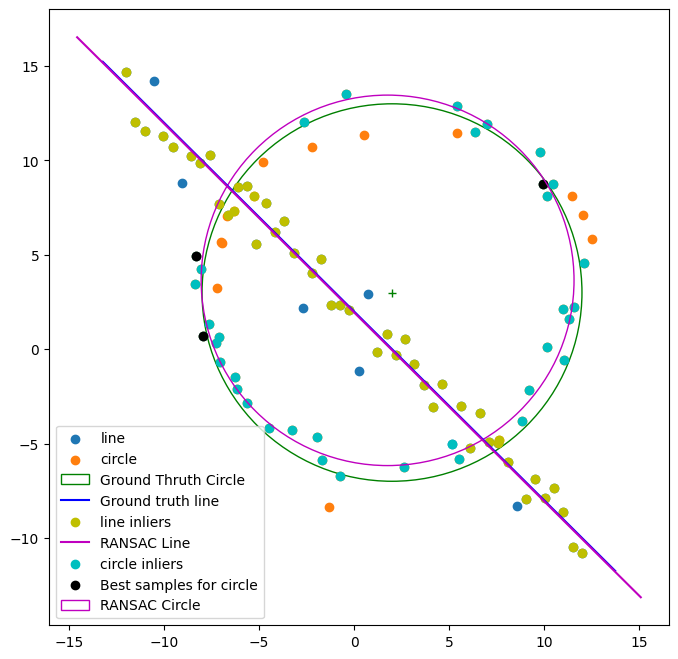

In [26]:
# Generation of a Noisy Point Set Conforming to a Line and a Circl e
import numpy as np
from scipy.optimize import minimize
from scipy import linalg
import matplotlib . pyplot as plt
#import tikzplotlib
# np . random . seed ( 0)
N = 100
half_n = N//2
r = 10
x0_gt , y0_gt = 2 , 3 # Center
s = r /16
t = np . random . uniform (0 , 2*np . pi , half_n )
n = s*np . random . randn ( half_n )
x , y = x0_gt + ( r + n)*np . cos ( t ) , y0_gt + ( r + n)*np . sin ( t )
X_circ = np . hstack ( ( x . reshape ( half_n , 1 ) , y . reshape ( half_n , 1 ) ) )
s = 1.
m, b = -1, 2
x = np . linspace(-12, 12 , half_n )
y = m*x + b + s*np . random . randn ( half_n )
X_line = np . hstack ( ( x . reshape ( half_n , 1 ) , y . reshape ( half_n , 1 ) ) )
X = np . vstack ( ( X_circ , X_line ) ) # All point s
fig , ax = plt.subplots (1 ,1 , figsize=(8 ,8))
ax . scatter( X_line [ : , 0 ] , X_line [ : , 1 ] , label= 'line')
ax.scatter( X_circ [ : , 0 ] , X_circ [ : , 1 ] , label = 'circle')
circle_get = plt.Circle( ( x0_gt , y0_gt ) , r , color = 'g', fill=False , label='Ground Thruth Circle' )
ax . add_patch (circle_get)
ax . plot ( ( x0_gt ) , ( y0_gt ) ,'+', color = 'g' )
x_min , x_max = ax . get_xlim ( )
x_ = np . array ( [ x_min , x_max ] )
y_ = m*x_ + b
plt.plot ( x_ , y_ ,color = 'b' , label= 'Ground truth line' )
plt.legend ( )



# Perform RANSAC-based line and circle fitting
best_line_model, best_line_inliers = ransac_line(X)
circle_best_model, circle_best_inliers, circle_best_indices, remnants = ransac_circle(X, best_line_inliers)

# Visualization of the RANSAC results
ax.scatter(X[best_line_inliers, 0], X[best_line_inliers, 1], color='y', label='line inliers')
x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = (-best_line_model[1] * x_ + best_line_model[2]) / best_line_model[1]
plt.plot(x_, y_, color='m', label='RANSAC Line')
ax.legend()

ax.scatter(remnants[circle_best_inliers, 0], remnants[circle_best_inliers, 1], color='c', label='circle inliers')
ax.scatter(remnants[circle_best_indices, 0], remnants[circle_best_indices, 1], color='k', label='Best samples for circle')
circle = plt.Circle((circle_best_model[0], circle_best_model[1]), circle_best_model[2], color='m', fill=False, label='RANSAC Circle')
ax.add_patch(circle)
ax.legend()
plt.show()
